In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
df = pd.read_csv('../datasets/train.csv')

In [4]:
# Remove irrelevant columns

In [5]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [6]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [7]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 1.5 * IQR_target
upper_bound_target = Q3_target + 1.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

In [8]:
# Check for missing values
df['property_bed_type'].isna().sum()

0

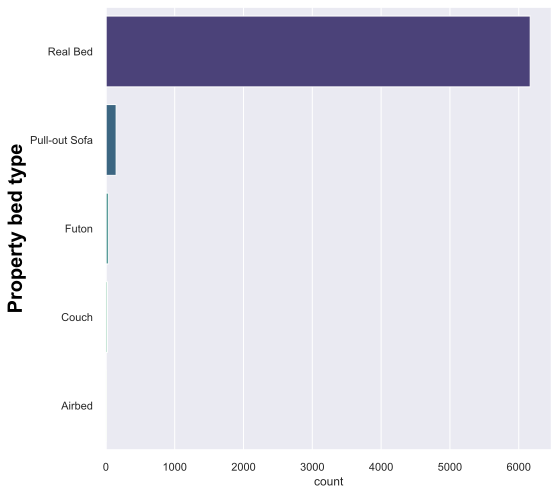

In [9]:
# Plot frequencies of each property_bed_type
sns.set(style='darkgrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_bed_type',data = df,order = df['property_bed_type'].value_counts().index,palette = "viridis")
plt.ylabel('Property bed type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

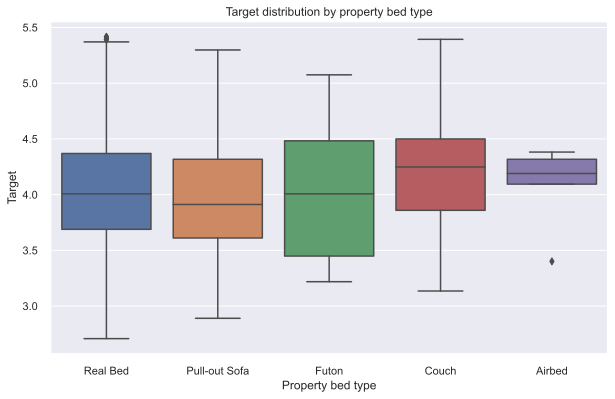

In [10]:
# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='property_bed_type', y='target', data=df)
ax.set_title('Target distribution by property bed type')
ax.set_xlabel('Property bed type')
ax.set_ylabel('Target')
plt.show()

In [11]:
# Generate the statistical description
df.groupby('property_bed_type')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
property_bed_type,,,,,,,,
Airbed,5.0,4.076942,0.393884,3.401197,4.094345,4.189655,4.317488,4.382027
Couch,23.0,4.186005,0.561378,3.135494,3.859343,4.248495,4.499810,5.393628
Futon,35.0,4.015692,0.562362,3.218876,3.448852,4.007333,4.482987,5.075174
Pull-out Sofa,149.0,3.976595,0.504451,2.890372,3.610918,3.912023,4.317488,5.298317
Real Bed,6167.0,4.021176,0.514060,2.708050,3.688879,4.007333,4.369448,5.416100


In [12]:
# Check if there are significant differences in price between the bed types
from scipy.stats import f_oneway

bed_type_groups = [group['target'] for name, group in df.groupby('property_bed_type')]
f_stat, p_value = f_oneway(*bed_type_groups)

if p_value < 0.05:
    print("There are significant differences in target values between bed types")
else:
    print("There are no significant differences in target values between bed types")


There are no significant differences in target values between bed types


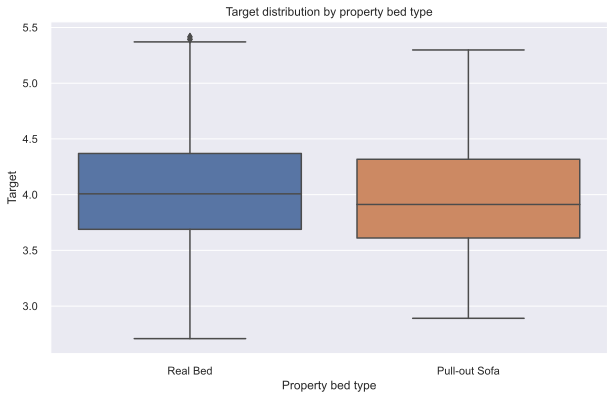

In [13]:
# Filter the dataframe to only include rows with property_bed_type that appear a lot
bed_type_counts = df['property_bed_type'].value_counts()
popular_bed_types = bed_type_counts[bed_type_counts > 100].index.tolist()
filtered_df = df[df['property_bed_type'].isin(popular_bed_types)]

# generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='property_bed_type', y='target', data=filtered_df)
ax.set_title('Target distribution by property bed type')
ax.set_xlabel('Property bed type')
ax.set_ylabel('Target')
plt.show()

In [14]:
# Generate the statistical description
filtered_df.groupby('property_bed_type')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
property_bed_type,,,,,,,,
Pull-out Sofa,149.0,3.976595,0.504451,2.890372,3.610918,3.912023,4.317488,5.298317
Real Bed,6167.0,4.021176,0.514060,2.708050,3.688879,4.007333,4.369448,5.416100


In [15]:
# Because of the reasons highlighted in this EDA, we have decided to remove property_bed_type
# as an attribute from our training set.